In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

from project_functions import *
import tracker

%matplotlib inline

In [9]:
dist_pickle = pickle.load(open("classifier.p", "rb" ))

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


/Users/iyed/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2 cars found
(array([424, 424, 424, ..., 519, 519, 519]), array([1104, 1105, 1106, ..., 1197, 1198, 1199]))


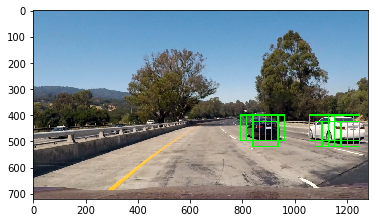

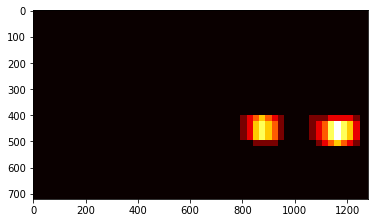

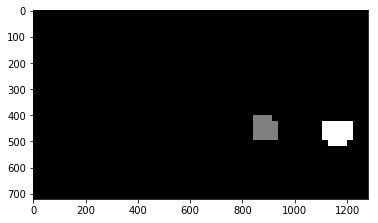

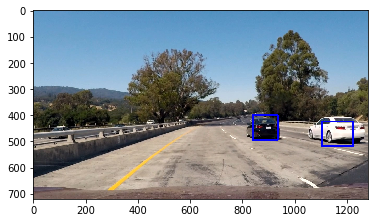

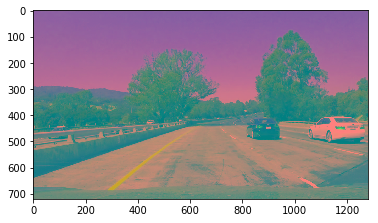

In [12]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, img_type='jpg'):
    
    draw_img = np.copy(img)
    if img_type == 'jpg':
        img = img.astype(np.float32)/255
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            scaled_test_features = X_scaler.transform(test_features)    
            test_prediction = svc.predict(scaled_test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = (
                    # (xbox_left, ytop_draw + ystart + win_draw),
                    (xbox_left, ytop_draw + ystart),
                    # (xbox_left + win_draw, ytop_draw + ystart),
                    (xbox_left + win_draw, ytop_draw + ystart + win_draw)
                )
                bbox_list.append(bbox)
                cv2.rectangle(
                    draw_img,
                    (xbox_left, ytop_draw + ystart),
                    (xbox_left + win_draw, ytop_draw + win_draw + ystart),
                    (0, 255, 0),
                    4
                )
                
    return draw_img, bbox_list

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

ystart = 400
ystop = 656
scale = 1.5
threshold = 2

img = mpimg.imread('./test_images/test1.jpg')
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
mpimg.imsave('./output_images/test1.jpg', out_img)
heat_map = np.zeros_like(img[:, :, 0]).astype(np.float)

heat_map = add_heat(heat_map, bbox_list)
plt.figure()
plt.imshow(heat_map, cmap='hot')

# Apply threshold to help remove false positives
heat_map = apply_threshold(heat_map, threshold)

plt.figure()
plt.imshow(heat_map, cmap='hot')
plt.imsave('./output_images/test1_heatmap.jpg', heat_map, cmap='hot')

labels = label(heat_map)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')


print((labels[0] == 2).nonzero())

output = draw_labeled_bboxes(img, labels)
plt.imsave('./output_images/test1_out.jpg', output)
plt.figure()
plt.imshow(output)

plt.figure()
plt.imshow(convert_color(mpimg.imread("./test1.jpg")))


In [ ]:
pipeline = tracker.Tracker(dist_pickle, threshold=1)
img = mpimg.imread('./test_images/test1.jpg')
output = pipeline.processframe(img)
plt.imshow(output)

In [ ]:
from moviepy.editor import VideoFileClip
p = tracker.Tracker(dist_pickle)

stream_output = './project_video_output.mp4'
clip = VideoFileClip('./project_video.mp4')
processed_clip = clip.fl_image(p)
processed_clip.write_videofile(stream_output, audio=False)